In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Lambda, Flatten, Reshape, Conv2D
from tensorflow.keras.datasets import mnist
from flows import Flow
from flows.affine import Planar, Radial
from layers import GatedConv2D, GatedConv2DTranspose, FlowLayer
tfd = tfp.distributions

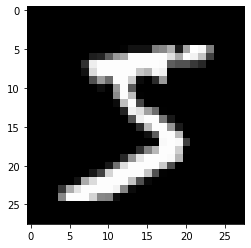

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train / 255
X_test = X_test / 255
plt.imshow(X_train[0], cmap='gray')

In [3]:
d = 64
n_layers = 8
flow = Flow(Planar())
for i in range(1, n_layers):
    flow(Planar())

In [10]:
def vae(wt, ht, flow, n_flows=1, hidden_units=64, z_size=64):
    p = flow.param_count(z_size)
    input_0 = Input((wt, ht, 1))
    def conv_downsample(x):
        g = GatedConv2D(hidden_units, 3, activation='linear')
        g_downsample = GatedConv2D(hidden_units, 3, strides=2)
        return g_downsample(g(x))
    def conv_upsample(x):
        g = GatedConv2DTranspose(hidden_units, 3, activation='linear')
        g_upsample = GatedConv2DTranspose(hidden_units, 3, strides=2)
        return g_upsample(g(x))
    h = conv_downsample(input_0)
    z_mu = Dense(z_size, activation='linear')(Flatten()(h))
    z_log_sigma = Dense(z_size, activation='linear')(Flatten()(h))
    params = Dense(flow.param_count(z_size), activation='linear')(Flatten()(h))
    z_0, z_k, ldj, kld = FlowLayer(flow)([z_mu, z_log_sigma, params])
    h_k = Dense(wt//2 * ht // 2, activation='linear')(z_k)
    x_out = conv_upsample(Reshape((wt//2, ht//2, 1))(h_k))
    output_0 = Conv2D(1, 1, activation='linear')(x_out)
    model = Model(inputs=input_0, outputs=output_0)
    model.compile(loss='mse', optimizer='adam')
    return model

In [11]:
x_train = np.expand_dims(X_train, axis=-1) #.reshape((-1, X_train.shape[1]*X_train.shape[2]))
model = vae(x_train.shape[1], x_train.shape[2], flow, n_flows=n_layers, z_size=d)

In [ ]:
model.fit(x_train, x_train, epochs=2, batch_size=128)

In [13]:
x_test = np.expand_dims(X_test, axis=-1) #X_test.reshape((-1, X_test.shape[1]*X_test.shape[2]))
x_pred = model.predict(x_test)

In [14]:
from tensorflow.keras.metrics import mean_squared_error
tf.math.reduce_mean(mean_squared_error(x_test, x_pred)).numpy()

0.074216574

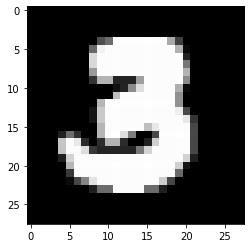

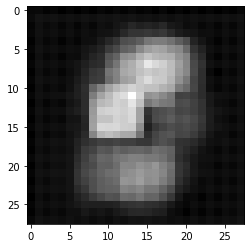

In [17]:
i = 200
plt.imshow(X_test[i], cmap='gray')
plt.show()
plt.imshow(x_pred[i].squeeze(), cmap='gray')
plt.show()